# Mettre en place notre environnement
________

La première chose que nous devons faire est de charger les bibliothèques et les ensembles de données que nous allons utiliser. Pour aujourd'hui, nous allons travailler avec deux ensembles de données : un contenant des chroniques de température dans le lit de la rivière (zone hyporhéique), et un autre contenant des les chroniques de différence de charge enregistré en **Volt**.

**Important!** Assurez-vous d'exécuter cette cellule vous-même ou le reste de votre code ne fonctionnera pas

In [1]:
# Delete the first line of the file 
T_measures = "../sampling_points/Point034/point034_T_measures.csv"
with open(T_measures, 'r') as file:
    all_lines = file.readlines()
    file.close()
if all_lines[0][0] != '"' or all_lines[0].strip()[-1] != '"':
    print(all_lines[0][-1], all_lines[0][0])
    all_lines.pop(0)
#all_lines[0] = '#,"Date Heure, GMT+01:00","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Hôte connecté (LGR S/N: 10117166)","Arrêté (LGR S/N: 10117166)",Fin de fichier (LGR S/N: 10117166) \n' all_lines[0] = '#,"Date Heure, GMT+01:00","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Hôte connecté (LGR S/N: 10117166)","Arrêté (LGR S/N: 10117166)",Fin de fichier (LGR S/N: 10117166) \n'
with open(T_measures, 'w') as file:
    for line in all_lines:
        file.write(line)



In [2]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# read in our data
capteur_riviere = pd.read_csv("../sampling_points/Point034/point034_P_measures.csv")
capteur_ZH = pd.read_csv("../sampling_points/Point034/point034_T_measures.csv")
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

# set seed for reproducibility
np.random.seed(0)

Nous sommes maintenant prêts à examiner quelques dates ! (Si vous le souhaitez, vous pouvez profiter de cette occasion pour jeter un coup d'œil à certaines des données).

# Imprimez le noms des colonnes
renommer les colonnes du fichier capteur_riviere :  	dates,tension_V,temperature_stream_C et celles du fichier capteur_ZH  :
#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C



# Transformez les données de différence de charge en mètres



In [3]:
# Rename columns
capteur_riviere.rename(columns = {'Unnamed: 1' : 'dates', 'Unnamed: 2' : 'tension_V', 'Unnamed: 3' : 'temperature_stream_C'}, inplace = True)
capteur_ZH.rename(columns = {'Titre de tracé : T520' : '#', 'Date Heure, GMT+01:00': 'dates' , 'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)':'temperature_depth_1_C' ,
                             'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).1':'temperature_depth_2_C' , 'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).2':'temperature_depth_3_C' ,
                             'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).3':'temperature_depth_4_C'}, inplace = True)
print(capteur_riviere.dtypes)
# Change types 
capteur_riviere['tension_V']=pd.to_numeric(capteur_riviere['tension_V'], errors  ='coerce')
capteur_riviere['temperature_stream_C']=pd.to_numeric(capteur_riviere['temperature_stream_C'], errors  ='coerce')
print(capteur_riviere.dtypes)
capteur_riviere.head()
capteur_ZH.head()
etalonage_capteur_riv.dtypes

Titre de tracé : point_montberneux    object
dates                                 object
tension_V                             object
temperature_stream_C                  object
Unnamed: 4                            object
Unnamed: 5                            object
Unnamed: 6                            object
dtype: object
Titre de tracé : point_montberneux     object
dates                                  object
tension_V                             float64
temperature_stream_C                  float64
Unnamed: 4                             object
Unnamed: 5                             object
Unnamed: 6                             object
dtype: object


Sensor_Name    object
P508           object
dtype: object

In [4]:
# Charge Calculation 
dUH = pd.to_numeric(etalonage_capteur_riv.loc[3,'P508'])
dUT = pd.to_numeric(etalonage_capteur_riv.loc[4,'P508'])
intercept = pd.to_numeric(etalonage_capteur_riv.loc[2,'P508'])
capteur_riviere['charge_M'] = ((capteur_riviere['tension_V'])-(capteur_riviere['temperature_stream_C'])*dUT-intercept)/(dUH)
capteur_riviere['charge_M'].head()

0         NaN
1   -0.020848
2    0.112499
3    0.016578
4   -0.009873
Name: charge_M, dtype: float64

# Traitement des dates
## Vérifiez le type de données de notre colonne de date
___

Imprimer les dates des deux fichiers

In [5]:
# Date impresion
print(capteur_riviere['dates'])
print(capteur_ZH['dates'])

0       Date Heure, GMT+01:00
1        06/27/16 12:00:00 PM
2        06/27/16 12:15:00 PM
3        06/27/16 12:30:00 PM
4        06/27/16 12:45:00 PM
                ...          
1456         07/12/2016 15:45
1457         07/12/2016 16:00
1458         07/12/2016 16:15
1459         07/12/2016 16:30
1460         07/12/2016 16:45
Name: dates, Length: 1461, dtype: object
0       06/27/16 12:15:00 PM
1       06/27/16 12:30:00 PM
2       06/27/16 12:45:00 PM
3       06/27/16 01:00:00 PM
4       06/27/16 01:15:00 PM
                ...         
1432    07/12/16 10:15:00 AM
1433    07/12/16 10:30:00 AM
1434    07/12/16 10:45:00 AM
1435    07/12/16 10:49:31 AM
1436    07/12/16 10:49:47 AM
Name: dates, Length: 1437, dtype: object


Remarquez qu'en bas de la sortie de `head()`, vous pouvez voir qu'il est dit que le type de données de cette colonne est "object". 

> Pandas utilise le dtype "object" pour stocker différents types de données, mais le plus souvent, lorsque vous voyez une colonne avec le dtype "object", elle contient des chaînes de caractères. 

Si vous consultez la documentation sur le dtype de Pandas [ici] (http://pandas.pydata.org/pandas-docs/stable/basics.html#dtypes), vous remarquerez qu'il existe également un dtype spécifique `datetime64`. Comme le dtype de notre colonne est `object` plutôt que `datetime64`, nous pouvons dire que Python ne sait pas que cette colonne contient des dates.

Nous pouvons aussi regarder uniquement le dtype de votre colonne sans imprimer les premières lignes si nous le souhaitons :

In [6]:
# check the data type of our date column
capteur_riviere.dtypes
capteur_riviere.dtypes['dates']

dtype('O')

You may have to check the [numpy documentation](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.dtype.kind.html#numpy.dtype.kind) to match the letter code to the dtype of the object. "O" is the code for "object", so we can see that these two methods give us the same information.

## Convertir nos colonnes de date en datetime
___

Maintenant que nous savons que notre colonne de date n'est pas reconnue comme une date, il est temps de la convertir pour qu'elle soit reconnue comme une date. Cette opération est appelée "analyse syntaxique des dates" car nous prenons une chaîne de caractères et identifions ses composants. Nous allons utiliser la fonction pd.to_datetime.

Nous pouvons indiquer à pandas le format de nos dates à l'aide d'un guide appelé ["strftime directive", sur lequel vous trouverez plus d'informations à ce lien] (http://strftime.org/). L'idée de base est que vous devez indiquer quelles parties de la date se trouvent où et quelle ponctuation se trouve entre elles. Il existe [de nombreuses parties possibles d'une date](http://strftime.org/), mais les plus courantes sont `%d` pour le jour, `%m` pour le mois, `%y` pour une année à deux chiffres et `%Y` pour une année à quatre chiffres.

Quelques exemples :

 * Le 17 janvier 2007 a le format "%m/%d/%y".
 * 17-1-2007 a le format "%d-%m-%Y".
 

In [7]:

capteur_riviere['dates'] = pd.to_datetime(capteur_riviere['dates'] , infer_datetime_format = True, errors = 'coerce')
# infer_datetime_format was used because there was diferents formats of datatime
capteur_riviere.dtypes

Titre de tracé : point_montberneux            object
dates                                 datetime64[ns]
tension_V                                    float64
temperature_stream_C                         float64
Unnamed: 4                                    object
Unnamed: 5                                    object
Unnamed: 6                                    object
charge_M                                     float64
dtype: object

Maintenant que nos dates sont analysées correctement, nous pouvons travailler avec celles-ci.

___
* Bien que nous spécifions le format de la date ici, il arrive parfois que vous rencontriez une erreur lorsque plusieurs formats de date sont présents dans une même colonne. Dans ce cas, vous pouvez demander à pandas de déduire le bon format de date. Vous pouvez le faire comme suit :

`capteur_riviere['date'] = pd.to_datetime(capteur_riviere['date'], infer_datetime_format=True)``

**Pourquoi ne pas toujours utiliser `infer_datetime_format = True?`** Il y a deux grandes raisons de ne pas toujours faire deviner à pandas le format de l'heure. La première est que pandas n'est toujours capable de trouver le bon format de date, surtout si quelqu'un a fait preuve de créativité dans la saisie des données. La seconde est que c'est beaucoup plus lent que de spécifier le format exact des dates.
____

In [8]:
capteur_ZH['dates'] = pd.to_datetime(capteur_ZH['dates'] , infer_datetime_format = True, errors = 'coerce')
capteur_ZH.head()

,#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C,Hôte connecté (LGR S/N: 10117166),Arrêté (LGR S/N: 10117166),Fin de fichier (LGR S/N: 10117166)
0,2,2016-06-27 12:15:00,13.834,13.858,13.882,13.834,NaN,NaN,NaN
1,3,2016-06-27 12:30:00,13.930,13.954,14.050,14.002,NaN,NaN,NaN
2,4,2016-06-27 12:45:00,13.882,13.954,14.026,13.954,NaN,NaN,NaN
3,5,2016-06-27 13:00:00,13.858,13.930,14.026,13.954,NaN,NaN,NaN
4,6,2016-06-27 13:15:00,13.882,13.930,14.002,13.930,NaN,NaN,NaN


## Tracer le jour du mois pour vérifier l'analyse de la date
___

L'un des plus grands dangers de l'analyse des dates est de mélanger les mois et les jours. La fonction to_datetime() a des messages d'erreur très utiles, mais il n'est pas inutile de vérifier que les jours du mois que nous avons extraits ont un sens. 

Pour ce faire, nous allons tracer un histogramme des jours du mois. Nous nous attendons à ce qu'il ait des valeurs entre 1 et 31 et, puisqu'il n'y a aucune raison de supposer que les glissements de terrain sont plus fréquents certains jours du mois que d'autres, une distribution relativement égale. (Avec un creux sur 31 car tous les mois n'ont pas 31 jours.) 

<AxesSubplot:>

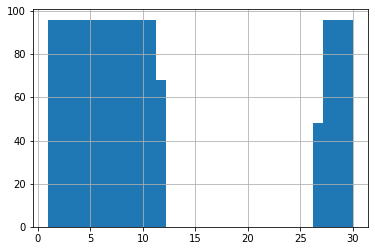

In [9]:
capteur_riviere['dates'].apply(lambda x: x.day).hist(bins = 31)
# Le trou s'explique par le fait que les données ont éte prises entre le 26 juin et le 12 juillet 

<AxesSubplot:>

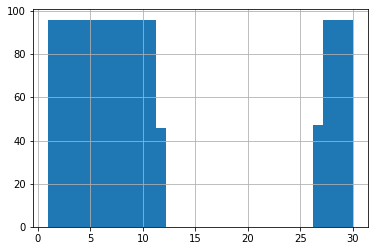

In [10]:
capteur_ZH['dates'].apply(lambda x: x.day).hist(bins = 31)
# idem 

# Valeurs aberrantes

L'un des plus grands défis du nettoyage des données est l'identification et le traitement des valeurs aberrantes. En termes simples, les valeurs aberrantes sont des observations qui sont significativement différentes des autres points de données. Même les meilleurs algorithmes d'estimation des paramètres automatique seront moins performants si les observations aberrantes ne sont pas nettoyées des données, car elles impliquent des simulations obsolètes des variables.



In [11]:
print(capteur_riviere.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Titre de tracé : point_montberneux  1461 non-null   object        
 1   dates                               1460 non-null   datetime64[ns]
 2   tension_V                           1460 non-null   float64       
 3   temperature_stream_C                1460 non-null   float64       
 4   Unnamed: 4                          1 non-null      object        
 5   Unnamed: 5                          1 non-null      object        
 6   Unnamed: 6                          1 non-null      object        
 7   charge_M                            1460 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 91.4+ KB
None


In [12]:
print(capteur_ZH.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   #                                   1437 non-null   int64         
 1   dates                               1437 non-null   datetime64[ns]
 2   temperature_depth_1_C               1435 non-null   float64       
 3   temperature_depth_2_C               1435 non-null   float64       
 4   temperature_depth_3_C               1435 non-null   float64       
 5   temperature_depth_4_C               1435 non-null   float64       
 6   Hôte connecté (LGR S/N: 10117166)   1 non-null      object        
 7   Arrêté (LGR S/N: 10117166)          1 non-null      object        
 8   Fin de fichier (LGR S/N: 10117166)  1 non-null      object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 101.2+ KB
None


## Identification des valeurs aberrantes

La présence de valeurs aberrantes dans les données peut avoir de nombreuses raisons. Parfois, les valeurs aberrantes peuvent être authentiques, alors que dans d'autres cas, elles peuvent être dues à des erreurs de saisie de données. Il est important de comprendre les raisons des valeurs aberrantes avant de les nettoyer.

Nous allons commencer le processus de recherche des valeurs aberrantes en exécutant les statistiques sommaires sur les variables. Pour ce faire, nous utilisons la fonction describe() ci-dessous, qui fournit un résumé statistique de toutes les variables quantitatives.




In [13]:
capteur_ZH.describe()

,#,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C
count,1437.000000,1435.000000,1435.000000,1435.000000,1435.000000
mean,720.000000,14.718190,14.503261,14.349288,14.098009
std,414.970481,0.721653,0.531363,0.423237,0.328534
min,2.000000,13.329000,13.642000,13.762000,13.690000
25%,361.000000,14.146000,14.098000,14.050000,13.882000
50%,720.000000,14.625000,14.409000,14.242000,14.002000
75%,1079.000000,15.127000,14.768000,14.505000,14.194000
max,1438.000000,17.320000,17.296000,17.034000,17.130000


In [14]:
capteur_riviere.describe()

,tension_V,temperature_stream_C,charge_M
count,1460.000000,1460.000000,1460.000000
mean,1.256888,14.896441,-0.016812
std,0.047302,1.142397,0.032176
min,0.652670,9.066000,-0.140099
25%,1.246590,14.203750,-0.025327
50%,1.262150,14.818000,-0.020557
75%,1.270010,15.555000,-0.009784
max,1.432100,18.342000,0.390494


## Tracez les graphiques de distribution pour les différentes variables

array([[<AxesSubplot:title={'center':'dates'}>,
        <AxesSubplot:title={'center':'tension_V'}>],
       [<AxesSubplot:title={'center':'temperature_stream_C'}>,
        <AxesSubplot:title={'center':'charge_M'}>]], dtype=object)

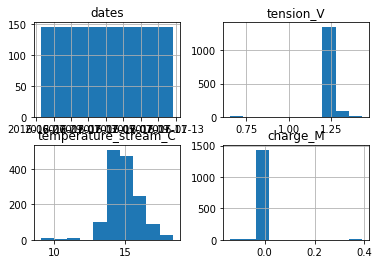

In [15]:
capteur_riviere.hist()

## Trouver les valeurs limites

In [16]:
idmax = capteur_riviere['charge_M'].idxmax()
idmin = capteur_riviere['charge_M'].idxmin()
print('La charge minimale est', capteur_riviere['charge_M'].min(), 'et la charge maximale est', capteur_riviere['charge_M'].max())
print('La temperature minimale est', capteur_riviere['temperature_stream_C'].min(), 'et la temperature maximale est', capteur_riviere['temperature_stream_C'].max())

La charge minimale est -0.14009855760190615 et la charge maximale est 0.39049449331450714
La temperature minimale est 9.066 et la temperature maximale est 18.342


<AxesSubplot:>

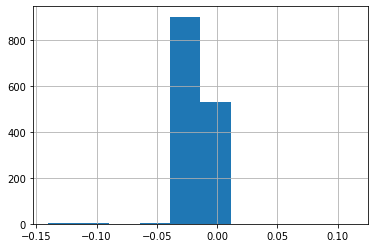

In [17]:
# Delete every value which is greater than a certain threshold
capteur_riviere.drop(capteur_riviere.loc[capteur_riviere['charge_M'] > 0.2].index)['charge_M'].hist()


<AxesSubplot:>

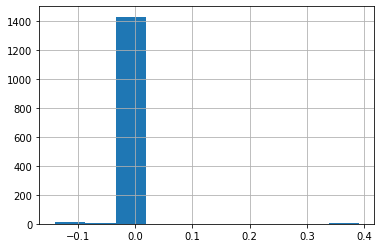

In [18]:
capteur_riviere['charge_M'].hist()
# Here we see the outliers whit the greatest values 

## Identification des valeurs aberrantes

La présence de valeurs aberrantes dans les données peut avoir de nombreuses raisons. Parfois, les valeurs aberrantes peuvent être authentiques, alors que dans d'autres cas, elles peuvent être dues à des erreurs de saisie de données. Il est important de comprendre les raisons des valeurs aberrantes avant de les nettoyer.

Nous allons commencer le processus de recherche des valeurs aberrantes en exécutant les statistiques sommaires sur les variables. Pour ce faire, nous utilisons la fonction describe() ci-dessous, qui fournit un résumé statistique de toutes les variables quantitatives.

## Tracez les graphiques de distribution pour les différentes variables

#### 1. Box plot

Le box plot est une manière standardisée d'afficher la distribution des données sur la base du résumé en cinq chiffres (minimum, premier quartile (Q1), médiane, troisième quartile (Q3) et maximum). Elle est souvent utilisée pour identifier la distribution des données et détecter les valeurs aberrantes. La ligne de code ci-dessous trace le box plot de la variable numérique 'Loan_amount'. 



<AxesSubplot:>

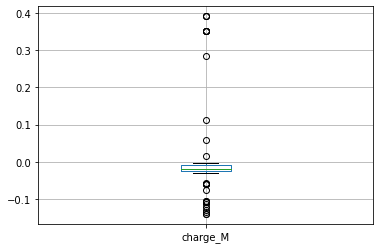

In [19]:
capteur_riviere.boxplot(column = ['charge_M'])

<AxesSubplot:>

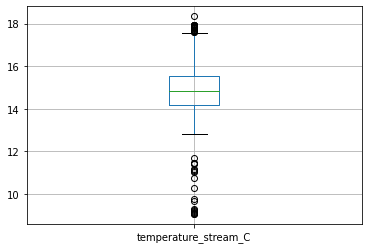

In [20]:
capteur_riviere.boxplot(column = ['temperature_stream_C'])

<AxesSubplot:>

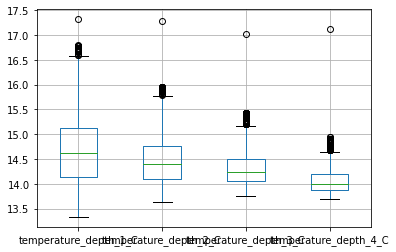

In [21]:
capteur_ZH.boxplot(column = ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])

## 2. Histogramme

Un histogramme est utilisé pour visualiser la distribution d'une variable numérique. Une valeur aberrante apparaît en dehors du modèle général de distribution. La ligne de code ci-dessous trace un histogramme de la variable 'Revenu', en utilisant la fonction hist(). A histogram is used to visualize the distribution of a numerical variable. An outlier will appear outside the overall pattern of distribution. The line of code below plots a histogram of the 'Income' variable, using the hist() function.

array([[<AxesSubplot:title={'center':'temperature_depth_1_C'}>,
        <AxesSubplot:title={'center':'temperature_depth_2_C'}>],
       [<AxesSubplot:title={'center':'temperature_depth_3_C'}>,
        <AxesSubplot:title={'center':'temperature_depth_4_C'}>]],
      dtype=object)

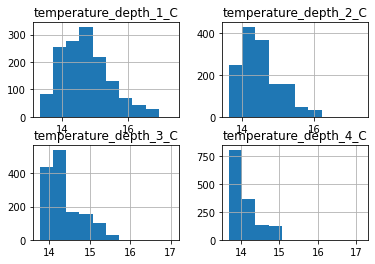

In [22]:
capteur_ZH.hist(column = ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])

## 3. Scatterplot

Un nuage de points permet de visualiser la relation entre deux variables quantitatives. Les données sont affichées sous la forme d'une collection de points, et tout point qui ne correspond pas au regroupement général des deux variables peut indiquer des valeurs aberrantes. 

génèrez un nuage de points entre les différentes variables de températures. 



<AxesSubplot:xlabel='temperature_depth_2_C', ylabel='temperature_depth_3_C'>

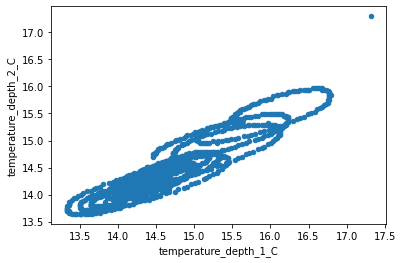

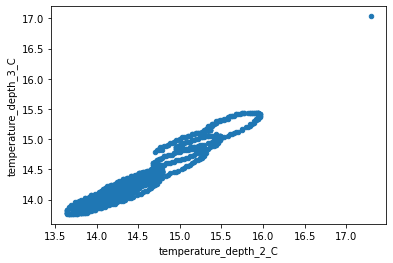

In [23]:
capteur_ZH.plot.scatter(x = 'temperature_depth_1_C' , y = 'temperature_depth_2_C')
capteur_ZH.plot.scatter(x = 'temperature_depth_2_C' , y = 'temperature_depth_3_C')
# We can see un obvious outlier in the upper right corner 

## Identification des valeurs aberrantes avec l'écart interquartile (IQR)

L'écart interquartile (IQR) est une mesure de la dispersion statistique et est calculé comme la différence entre les 75e et 25e percentiles. Il est représenté par la formule IQR = Q3 - Q1. Les  lignes de code ci-dessous calculent et impriment l'écart interquartile pour chacune des variables de l'ensemble de données.  La règle générale est que tout ce qui n'est pas dans la plage de (Q1 - 1,5 IQR) et (Q3 + 1,5 IQR) est une valeur aberrante et peut être supprimé.

### Fonctions d'assistance

Ecrire des fonctions afin d'examiner chaque colonne des deux fichiers de données de terain et de calculer les 1er et 3e quartiles, l'intervalle inter-quartile et le minimum et le maximum. Toute valeur en dehors du minimum et du maximum est une valeur aberrante.

<AxesSubplot:>

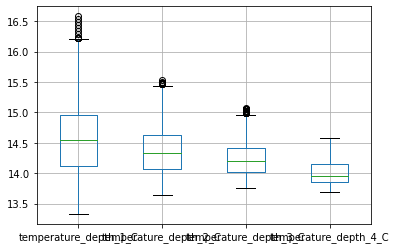

In [24]:
def remove_Outliers(data, col, treshold = 1.5):
    if type(col) is str :
        Q3 = data[col].quantile(0.75)
        Q1 = data[col].quantile(0.25)
        IQR = Q3 - Q1
        lower_range = Q1 - treshold*IQR
        upper_range = Q3 + treshold*IQR
        outlier_free_list = [x for x in data[col] if ((x > lower_range) & (x < upper_range))]
        filtered_data = data.loc[data[col].isin(outlier_free_list)]
        return  filtered_data
    elif len(col)>1:
        filtered_data = remove_Outliers(data, col[0])
        for i in col[1:]:
            filtered_data = remove_Outliers(filtered_data, i)      
        return filtered_data
 
filtered_data = remove_Outliers(capteur_ZH, ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])
filtered_data.boxplot(column = ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])


### Résolution de la distribution asymétrique…

A partir de nos données dans un histogramme, nous pouvons obtenir une distribution asymétrique des données. Une seule grande barre avec de minuscules barres à gauche ou à droite (ou les deux) est un signe révélateur que des valeurs aberrantes peuvent être présentes dans les données et cela signifie que notre bel histogramme, bien rangé et normalement distribué, est complètement caché et obscurci par le seul grand bar.


Lorsque nous observons ce modèle, nous devons supprimer les valeurs aberrantes, puis voir à quoi ressemble la nouvelle distribution. Si nous voulons vérifier la présence de valeurs aberrantes, une boîte à moustaches rapide confirmera ou refusera…


C'est ce que l'on a déjà fait dans la partie "Trouver la valeur limite".


## Suppression des valeurs aberrantes et visualisation du résultat

Après avoir fait tout le gros du travail dans les fonctions d'assistance, nous pouvons maintenant supprimer les lignes des données qui contiennent des valeurs aberrantes en dehors de | - et - | moustaches…



## Expliquez le résultat
est ce que cette méthodologie vous semble suffisante? Tentez de trouver les limites de cette méthodologie?
Que pouvez vous apportez aux fonctions afin de les améliorer? 

Une limite de cette méthodologie est qu'elle est arbitraire et pas adaptable : tous les points très loin de la mediane ne sont pas forcement aberrants. C'est pourquoi le paramètre 1.5 est devenue une variable de la function. 

## Valeurs abérantes avec la méthode score Z 
Il s'agit d'une unité mesurée en écart-type. Fondamentalement, il s'agit d'une mesure de la distance entre le score brut et la moyenne. Il est compris entre -3 et +3, où 0 = moyenne et 1 = écart-type, c'est-à-dire une distribution normale.

Cette méthode suggère qu'en tout point de données il existe une relation entre l'écart-type et la moyenne. Le score Z permet de trouver la distribution des données où la moyenne est égale à 0 et l'écart-type à 1, c'est-à-dire une distribution normale. Vous devez vous demander en quoi cela peut nous aider à identifier les valeurs aberrantes ? En calculant le score Z, nous redimensionnons et centrons les données et recherchons les points de données qui sont trop éloignés de zéro. Ces points de données qui sont trop éloignés de zéro seront traités comme des valeurs aberrantes. Dans la plupart des cas, un seuil de 3 ou -3 est utilisé, c'est-à-dire que si la valeur du score Z est supérieure ou inférieure à 3 ou -3 respectivement, ce point de données sera identifié comme aberrant.

Formule pour le score Z = (Observation - Moyenne)/Écart-type

z = (X - μ) / σ

Ecrire des functions afin de pouvoir appliquer cette méthodologie aux données

<AxesSubplot:>

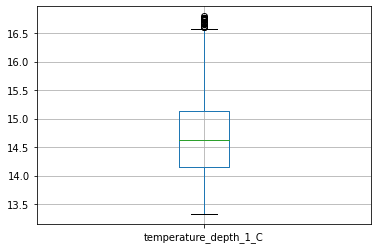

In [25]:
def remove_Z_outliers(data, col, treshold = 3):
    if type(col) is str :
        mean = data[col].mean()
        std = data[col].std()
        outlier_free_list = [x for x in data[col] if (np.abs(x-mean)/std <treshold)]
        filtered_data = data.loc[data[col].isin(outlier_free_list)]
        return  filtered_data
    else:
        filtered_data = remove_Z_outliers(data, col[0])
        for i in col[1:]:
            filtered_data = remove_Z_outliers(filtered_data, i)       
        return filtered_data

res = remove_Z_outliers(capteur_ZH, ['temperature_depth_1_C','temperature_depth_1_C'])
res.boxplot( 'temperature_depth_1_C')

<AxesSubplot:>

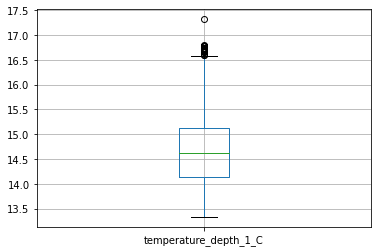

In [26]:
capteur_ZH.boxplot( 'temperature_depth_1_C')

<AxesSubplot:xlabel='temperature_depth_1_C', ylabel='temperature_depth_2_C'>

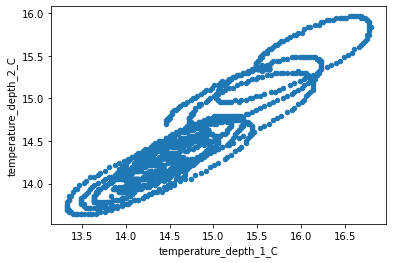

In [27]:
res.plot.scatter(x = 'temperature_depth_1_C' , y = 'temperature_depth_2_C')

## Comparer les deux méthodologies, donner leurs avantages et leurs limitations
Vous pouvez proposer des alternatives.


On peut faire le même commentaire pour la méthodologie Z-score. Elle est arbitraire et pas adaptable : tous les points très loin de la mediane ne sont pas forcement aberrants. C'est pourquoi le paramètre 3 est devenue une variable de la function. 
Le Z-score a tout de même comme avantage de préserver 99% des valeures d'une gaussiene. 


## Proposer une fonction permettant d'aller des données brutes jusqu'au premier traitement des données.

N'oubliez pas de permettre à l'utilisateur de pouvoir prendre des décisions et de l'aider à prendre ces décisions
Pensez à indiquer à l'utilisateur si le jeu de données est utilisable, quels sont les capteurs défaillant, quel semble être l'orientation des échanges nappe-rivière, les données de différence de charge semblent t'elles données les mêmes informations que les données du profils de température.

Votre function doit prendre en entrée, les trois fichiers et proposer au fur et à mesure de son dérouler des propositions à l'utilisateur.


In [29]:


def upper_cut(data, col, treshold = 0.2):
    if type(col) is str :
        res = data.drop(data.loc[data[col] > treshold].index)
        return res
    elif len(col)>1:
        filtered_data = upper_cut(data, col[0], treshold)
        for i in col[1:]:
            filtered_data = upper_cut(filtered_data, i, treshold)    
        return filtered_data

def under_cut(data, col, treshold = 0.2):
    if type(col) is str :
        res = data.drop(data.loc[data[col] < treshold].index)
        return res
    elif len(col)>1:
        filtered_data = upper_cut(data, col[0], treshold)
        for i in col[1:]:
            filtered_data = upper_cut(filtered_data, i, treshold)    
        return filtered_data
    
def processing(T_measures = "../sampling_points/Point034/point034_T_measures.csv",
               P_measures ="../sampling_points/Point034/point034_P_measures.csv",
               config = "../configuration/pressure_sensors/P508.csv"):
    with open(T_measures, 'r') as file:
        all_lines = file.readlines()
        file.close()
    if all_lines[0][0] != '"' or all_lines[0].strip()[-1] != '"':
        print(all_lines[0][-1], all_lines[0][0])
        all_lines.pop(0)
    #all_lines[0] = '#,"Date Heure, GMT+01:00","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)","Hôte connecté (LGR S/N: 10117166)","Arrêté (LGR S/N: 10117166)",Fin de fichier (LGR S/N: 10117166) \n' 
    with open(T_measures, 'w') as file:
        for line in all_lines:
            file.write(line)
    capteur_riviere = pd.read_csv(P_measures)
    capteur_ZH = pd.read_csv(T_measures)
    etalonage_capteur_riv = pd.read_csv(config)
    np.random.seed(0)
    capteur_ZH.head()
    capteur_riviere.rename(columns = {'Unnamed: 1' : 'dates', 'Unnamed: 2' : 'tension_V', 'Unnamed: 3' : 'temperature_stream_C'}, inplace = True)
    capteur_ZH.rename(columns = {'Titre de tracé : T520' : '#', 'Date Heure, GMT+01:00': 'dates' , 'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température)':'temperature_depth_1_C' , 'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).1':'temperature_depth_2_C' , 'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).2':'temperature_depth_3_C' , 'Temp., °C (LGR S/N: 10117166, SEN S/N: 10117166, LBL: Température).3':'temperature_depth_4_C'}, inplace = True)
    print(capteur_riviere.dtypes)
    capteur_riviere['tension_V']=pd.to_numeric(capteur_riviere['tension_V'], errors  ='coerce')
    capteur_riviere['temperature_stream_C']=pd.to_numeric(capteur_riviere['temperature_stream_C'], errors  ='coerce')
    print(capteur_riviere.dtypes)
  
    etalonage_capteur_riv.dtypes
    dUH = pd.to_numeric(etalonage_capteur_riv.loc[3,'P508'])
    dUT = pd.to_numeric(etalonage_capteur_riv.loc[4,'P508'])
    intercept = pd.to_numeric(etalonage_capteur_riv.loc[2,'P508'])
    capteur_riviere['charge_M'] = ((capteur_riviere['tension_V'])-(capteur_riviere['temperature_stream_C'])*dUT-intercept)/(dUH)
    capteur_riviere['dates'] = pd.to_datetime(capteur_riviere['dates'] , infer_datetime_format = True, errors = 'coerce')
    capteur_ZH['dates'] = pd.to_datetime(capteur_ZH['dates'] , infer_datetime_format = True, errors = 'coerce')
    print(capteur_riviere.info())
    print(capteur_ZH.info())
    capteur_ZH.describe()
    capteur_riviere.describe()
    capteur_riviere['temperature_stream_C'].hist()
    print('La charge minimale est', capteur_riviere['charge_M'].min(), 'et la charge maximale est', capteur_riviere['charge_M'].max())
    print('La temperature minimale est', capteur_riviere['temperature_stream_C'].min(), 'et la temperature maximale est', capteur_riviere['temperature_stream_C'].max())
    print("Raw data")
    capteur_riviere['charge_M'].hist()
    capteur_riviere.boxplot(column = ['charge_M'])
    capteur_riviere.boxplot(column = ['temperature_stream_C'])
    #capteur_ZH.boxplot(column = ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])
    capteur_ZH.hist(column = ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])
    capteur_ZH.plot.scatter(x = 'temperature_depth_1_C' , y = 'temperature_depth_2_C')
    capteur_ZH.plot.scatter(x = 'temperature_depth_2_C' , y = 'temperature_depth_3_C')
    def id(data, col, treshold):
        return data
    mode = input("Remove temp outlier method (None, up_cut, un_cut, Z_score, IQ) :" )
    methods = {'up_cut' : upper_cut, 'un_cut' : under_cut, 'Z_score' : remove_Z_outliers, 'IQ' : remove_Outliers, 'None' : id}
    treshold = input("Threshold (press enter for default):")
    if treshold == '':
        filtered_temp = methods[mode](capteur_ZH, col =  ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])
    else:
        treshold = int(treshold)
        filtered_temp = methods[mode](capteur_ZH, col =  ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'], treshold = treshold)
    
    #filtered_temp.boxplot(column = ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])
    filtered_temp.hist(column = ['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C'])
    filtered_temp.plot.scatter(x = 'temperature_depth_1_C' , y = 'temperature_depth_2_C')
    filtered_temp.plot.scatter(x = 'temperature_depth_2_C' , y = 'temperature_depth_3_C')
    
    mode = input("Remove Pressure outlier method (None, up_cut, un_cut, Z_score, IQ) :" )

    treshold = input("Threshold (press enter for default):")
    if treshold == '':
        filtered_p = methods[mode](capteur_riviere, col =  ['temperature_stream_C','charge_M'])
    else:
        treshold = int(treshold)
        filtered_p = methods[mode](capteur_riviere, col =  ['temperature_stream_C','charge_M'], treshold = treshold)
    filtered_p['charge_M'].hist()
    filtered_p.boxplot(column = ['charge_M'])
    filtered_p.boxplot(column = ['temperature_stream_C'])
    return filtered_p,filtered_temp



Titre de tracé : point_montberneux    object
dates                                 object
tension_V                             object
temperature_stream_C                  object
Unnamed: 4                            object
Unnamed: 5                            object
Unnamed: 6                            object
dtype: object
Titre de tracé : point_montberneux     object
dates                                  object
tension_V                             float64
temperature_stream_C                  float64
Unnamed: 4                             object
Unnamed: 5                             object
Unnamed: 6                             object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Titre de tracé : point_montberneux  1461 non-null   object        
 1   dates   

KeyError: ''

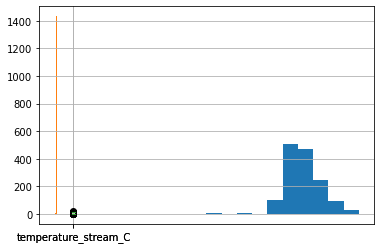

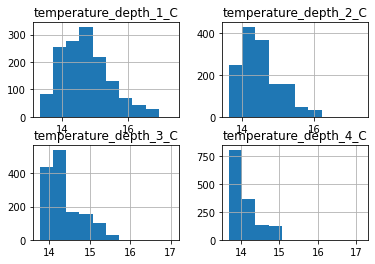

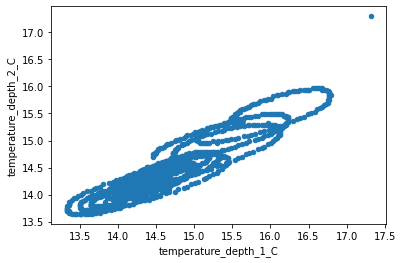

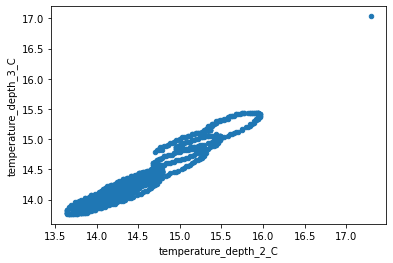

In [30]:
processing()




# Deux autres jeux de données sont disponibles sur le répertoire github.
Votre rôle est de traiter et d'analyser ces données avec la méthodologie que vous avez développé.

In [ ]:
processing((T_measures = "../sampling_points/Point046/point046_T_measures.csv",
               P_measures ="../sampling_points/Point046/point046_P_measures.csv",
               config = "../configuration/pressure_sensors/P508.csv")

In [ ]:
processing((T_measures = "../sampling_points/Point047/point047_T_measures.csv",
               P_measures ="../sampling_points/Point047/point047_P_measures.csv",
               config = "../configuration/pressure_sensors/P508.csv")